In [1]:
using LinearAlgebra
using LaTeXStrings
#using Plots
#gr()
using FFTW # for Fourier transforms
using Polynomials

<h2>Numerical</h2>

In [4]:
function NNTBHamiltonian(N,J; periodic=true)
    # nearest neighbour tight binding hamiltonian in real space
    H = zeros(N,N)
    for n in 1:N-1
        H[n+1,n] = -J
        H[n,n+1] = -J
    end
    if periodic
        H[1,N] = -J
        H[N,1] = -J
    end
    return H
end

NNTBHamiltonian (generic function with 1 method)

In [5]:
function translation(N)
    # translation operator in real space
    T = zeros(N,N)
    T[1,N] = 1.0 
    for n in 1:N-1 
        T[n+1,n] = 1.0
    end  
    return T
end

translation (generic function with 1 method)

In [6]:
function matched_eigen(T)
    # for block diagonal matrix T: return eigendecomposition in the same order as the original basis
    evals, evecs = eigen(T) # unordered spectrum, random phased evecs
    
    for i in 1:length(evals)
        maxindex = argmax(abs.(evecs[i,i:end])) + (i - 1) # scan row for first maximum value (ignoring the first i-1 ordered columns)
        # swap ith column for column with maximum value (swap eigenvalues too)
        evecs[:,[i,maxindex]] = evecs[:,[maxindex,i]]
        evals[[i,maxindex]] = evals[[maxindex,i]]
    end

    return evals, evecs
end

matched_eigen (generic function with 1 method)

In [7]:
function singleExHamiltonian(H_bath,δ,g; i=size(H_bath,1)+1, real_basis)
    # single excitation hamiltonian
    N = size(H_bath,1)
    H = zeros(N+1,N+1) 
    # H_A
    H[1,1] = δ # |e><e|
    # H_B
    H[2:end,2:end] = H_bath # |i><i'| if real=true and |k><k'| if real=false
    if real_basis
        # H_I
        H[1,i] = g # |e,vac><g,i|
        H[i,1] = g # |g,i><e,vac|
    else      
        # H_I
        H[1,2:end] = ones(N) .* g ./ √N # atom absorbs a photon from bath |e,vac><g,k|
        H[2:end,1] = ones(N) .* g ./ √N # atom emits a photon into the bath |g,k><e,vac|
    end
    return H
end

singleExHamiltonian (generic function with 1 method)

In [8]:
function evolveState(ψ_0,H_full,times; real_basis)
    fidelity = zeros(length(times)) # evolution of fidelity to initial state
    bath_distribution = zeros(length(ψ_0)-1, length(times)) # evolution of bath probability distribution

    Δt = (times[end] - times[1]) / length(times)
    U = exp(-1im * H * Δt) # unitary evolution matrix for timestep Δt

    ψ_old = ψ_0
    for i in 1:length(times)
        ψ_new = U * ψ_old  # Schrodinger's equation 
        fidelity[i] = abs2(adjoint(ψ_0) * ψ_new) # Born's rule
        if real_basis
            bath_distribution[:,i] = abs2.(ψ_new[2:end])
        else
            # ψ_t_real = recipToReal * ψ_t[2:end] # rotate into real space
            ψ_new_real = √N * ifft(ψ_new[2:end]) # fft relationship between real and reciprocal basis (note √N to correct for the asymmetrical placing of normalisation in fft/ifft functions)
            bath_distribution[:,i] = abs2.(ψ_new_real) # each column is a probability distribution
        end
        ψ_old = ψ_new
    end
    return fidelity, bath_distribution
end

evolveState (generic function with 1 method)

<h3>Bath (& translation) egienstates and density of states</h3>

<h5>Energy eigenstates</h5>

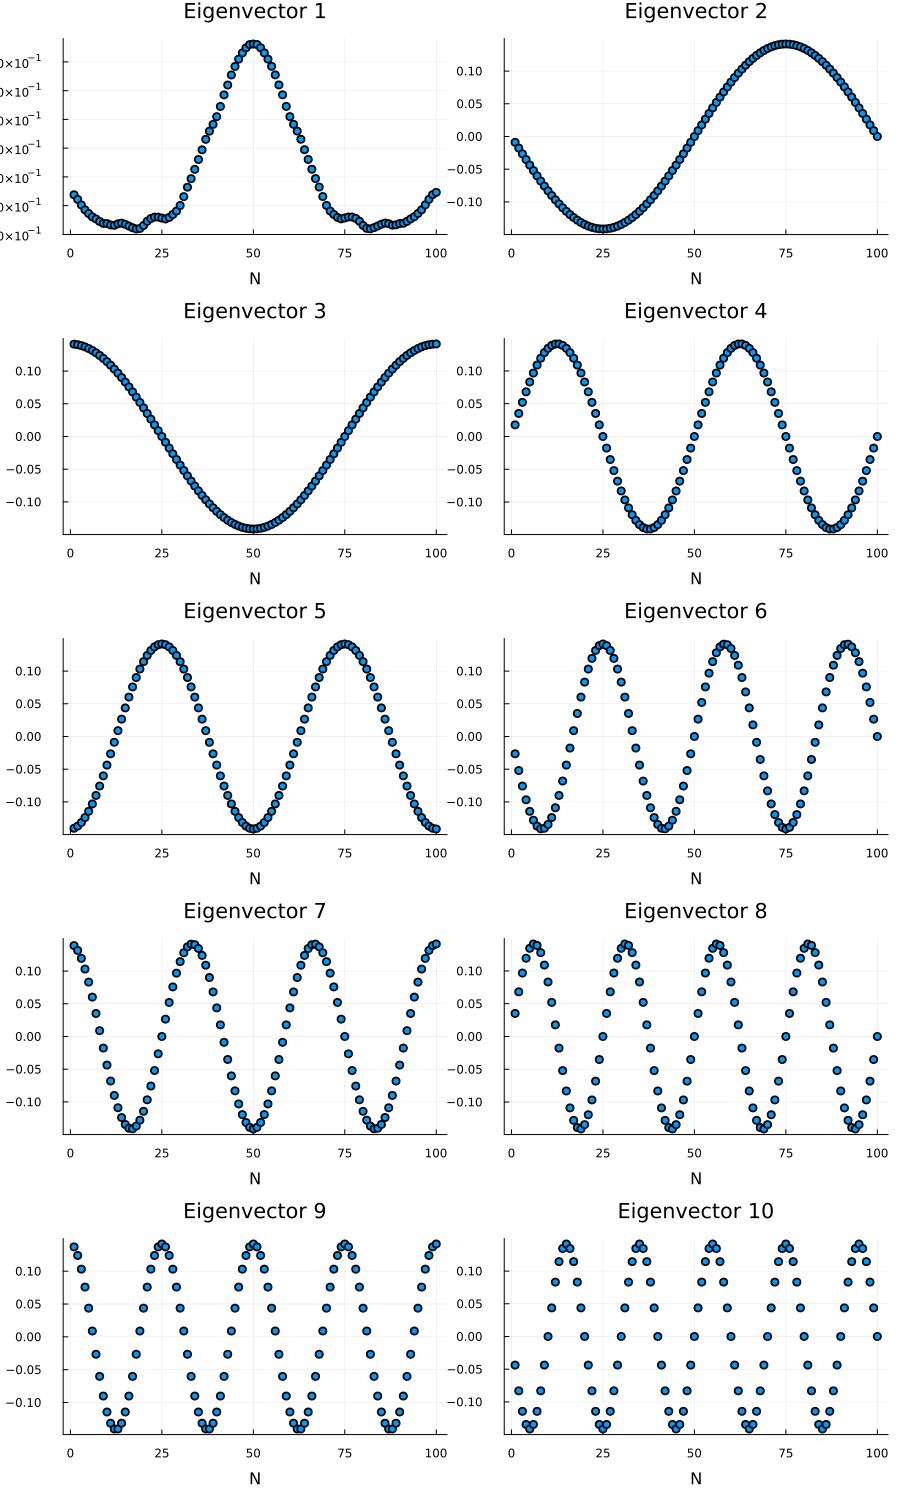

GKS: Possible loss of precision in routine SET_WINDOW


In [13]:
using Plots
# real space eigenvectors
fig = scatter(layout=(5, 2), size=(300*3, 300*5))

for i in 1:10
    scatter!(collect(1:N), evecs[:,i], title="Eigenvector $(i)", xlab="N", ylab="", legend=false, subplot=i)
end

display(fig)

<h5>Wavenumber via translation operator</h5>

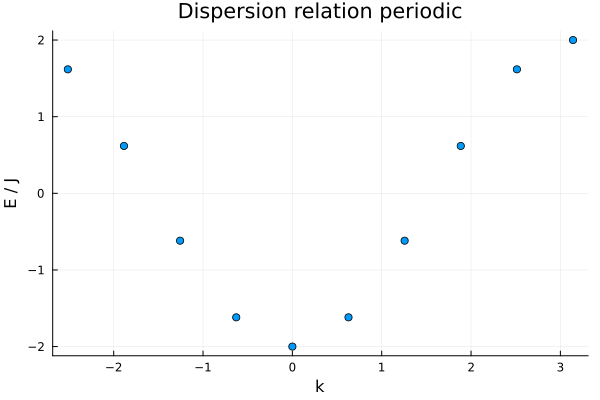

In [116]:
# plot dispersion relation
using Plots
scatter(k, evals_Hb, title="Dispersion relation periodic", xlab="k", ylab="E / J", legend=false)

<h5>Wavenumber via fourier transform</h5>

In [ ]:
# rotate H_bath eigenspace to try to go from cosines and sines to exponentials
evecs_new = Complex.(evecs)
counter = 0
evals = round.(evals, digits=8)

for n in 1:2:100
    i,j... = findall(==(evals[n]), evals) # check for degenerate states and record their indeces
    if isempty(j) == true
        continue
    else
        counter += 1
        j = j[1]
        # old basis
        cos = evecs[:,i]
        sin = evecs[:,j]
        # new basis
        evecs_new[:,i] = cos .+ 1im.*sin
        evecs_new[:,j] = cos .- 1im.*sin
    end
end

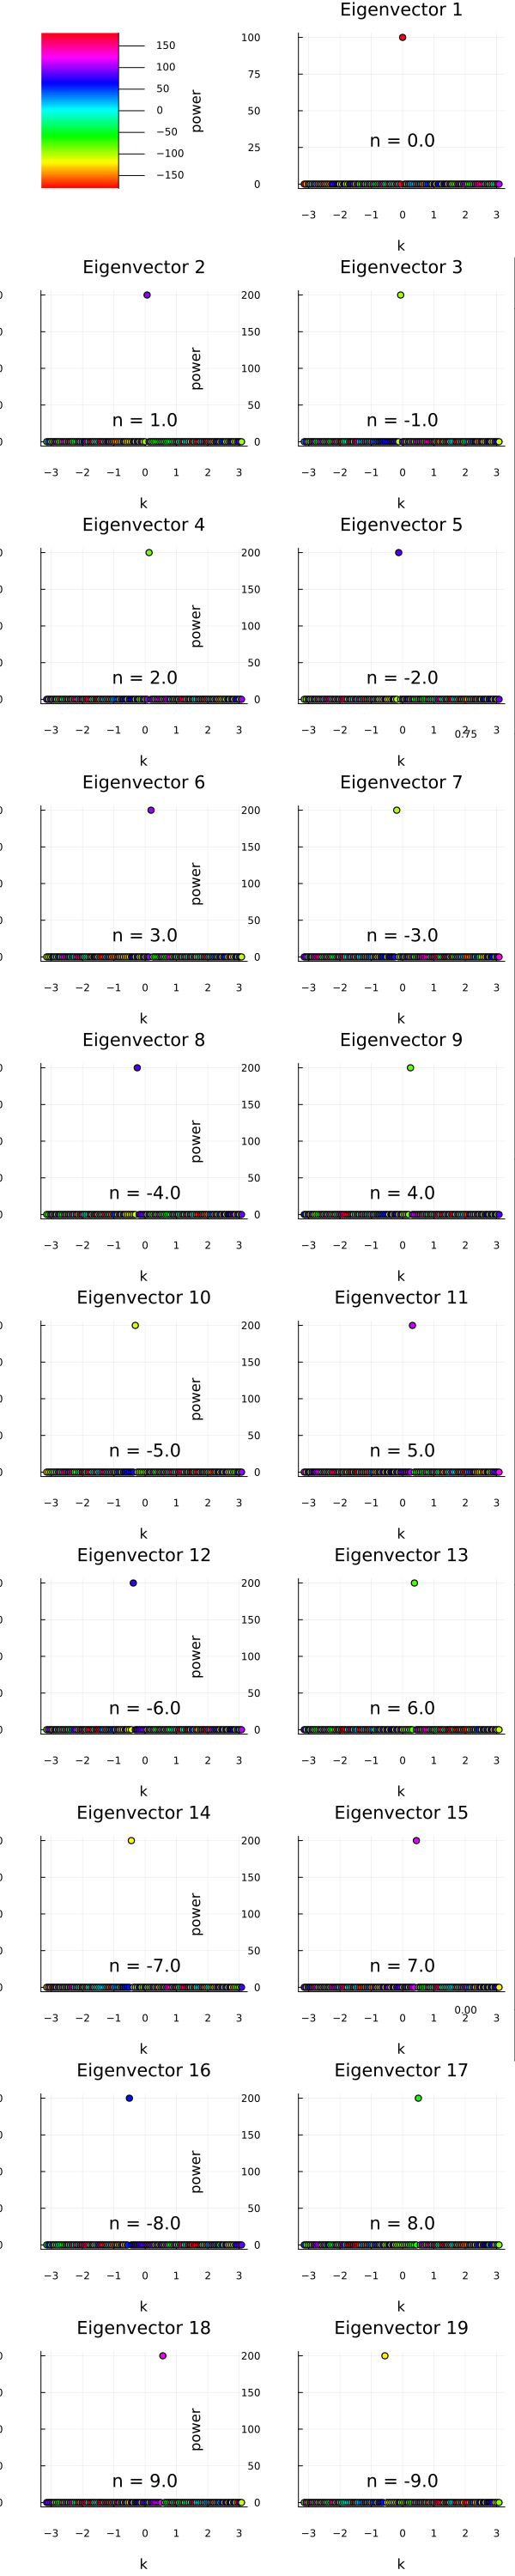

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [ ]:
# reciprocal space eigenvectors
fig = scatter(layout=(10, 2), size=(300*2, 300*10))
peaks = zeros(Int, N) # store positive peak index of each eigenvector
n = zeros(N) # multiple of fundamental freq (2π/N)

# perform FFT, note that this algorithm ASSUMES periodic bcs
for i in 2:20
    evecs_fft = fftshift(fft(evecs_new[:,i-1])) # match with negative freqs
    pwr_spectrum = abs2.(evecs_fft)
    phase = angle.(evecs_fft) .* 180 ./ π
    peaks_i = findall(>(40), pwr_spectrum) # indeces of all peaks
    peaks[i-1] = peaks_i[end]              
    n[i-1] = round(k[peaks[i-1]] * N / 2π)
    annotate!(fig[i],(0,30, "n = $(n[i-1])"))
    if length(peaks_i) > 1
        phase_diff = mod(trunc(phase[peaks_i[end]] - phase[peaks_i[1]]), 360)
        scatter!(k, pwr_spectrum, marker_z = phase, subplot=i, title="Eigenvector $(i-1)", xlab="k", ylab="power", color=:hsv, colorbar= false, legend=false)
        annotate!(fig[i],(0,40, "∆φ = $(phase_diff)"))
    else
        scatter!(k, pwr_spectrum, marker_z = phase, subplot=i, title="Eigenvector $(i-1)", xlab="k", ylab="power", color=:hsv, colorbar= false, legend=false)
    end
end

scatter!([NaN], [NaN],marker_z = [0.0],color = :hsv,clim = (-180, 180),colorbar = true,subplot = 1,colorbar_titlefont = font(8))

#savefig("Rotated_Eigenvectors_spectrum.png")
display(fig)

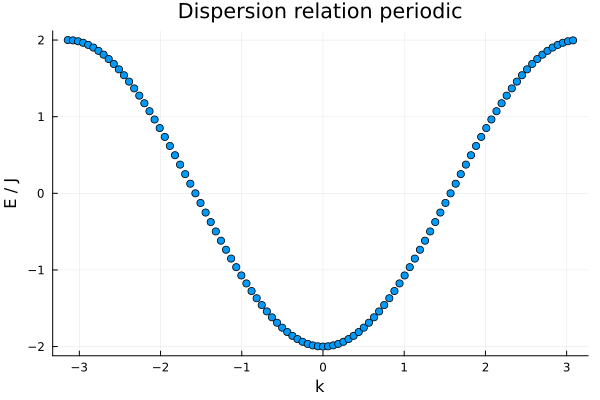

In [ ]:
# order eigenvectors by increasing k
for i in 1:N
    evecs_fft = fftshift(fft(evecs_new[:,i])) # match with negative freqs
    pwr_spectrum = abs2.(evecs_fft)
    peaks_i = findall(>(30),pwr_spectrum) # indeces of all peaks
    peaks[i] = peaks_i[end]               # index of positive peak
    n[i] = k[peaks[i]] * N / 2π
end

sort = sortperm(n)             # index permutation that would sort n in ascending order
k_evals = (2π / N) .* n[sort]  # extracted ks in ascending order
evals = evals[sort]
scatter(k_evals, evals, title="Dispersion relation periodic", xlab="k", ylab="E / J", legend=false)
#savefig("Dispersion_ring.png")

<h5>Density of states</h5>

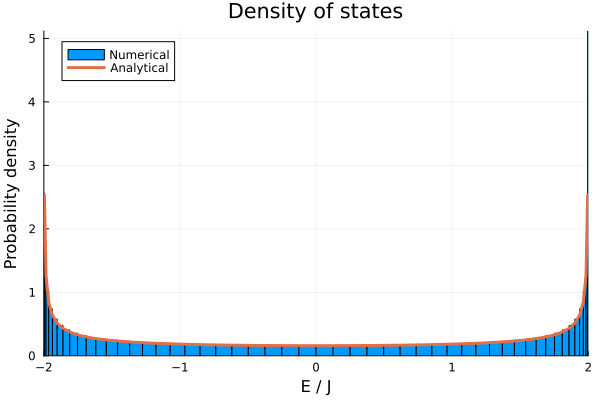

In [20]:
densityOfStates(E) = (π * √(4 * J^2 - E^2))^(-1) # analytical expression
D_E = densityOfStates.(evals_Hb[2:end-1])
edges = unique(round.(evals_Hb, digits=8)) # space as it is spaced in the spectrum of H

using Plots
histogram(round.(evals_Hb, digits=8), bins = edges, xlim = (-2, 2),title="Density of states", xlab="E / J", ylab="Probability density", normalize= true, label="Numerical")
plot!(evals_Hb[2:end-1], D_E, lw=3, label="Analytical")

<h3>Full Hamiltonian evolution</h3>

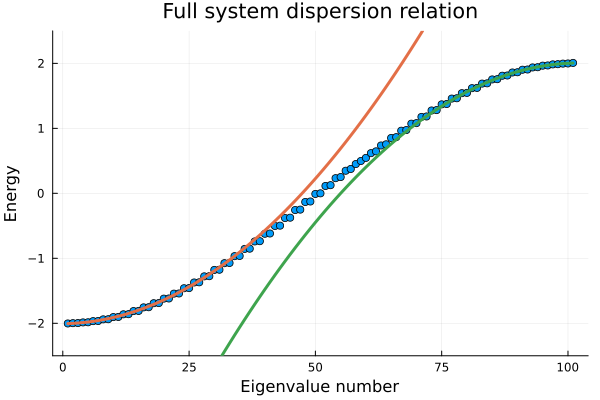

In [24]:
# plot dispersion relation
using Plots
x = collect(1:length(evals_H))
p1_fit = fit(x[1:25], evals_H[1:25], 2)
p2_fit = fit(x[end-25:end], evals_H[end-25:end], 2)
scatter(1:length(evals_H) , evals_H, title="Full system dispersion relation", xlab="Eigenvalue number", ylab="Energy", legend=false)
plot!(x, p1_fit.(x), ylim=(-2.5,2.5), label="Parabola 1", lw=3)
plot!(x, p2_fit.(x), ylim=(-2.5,2.5), label="Parabola 2", lw=3)

In [ ]:
# sample script
N,J,δ,g = 100, 1.0, 1.9, 31.62

# bath hamiltonian and spectrum
H_bath = NNTBHamiltonian(N,J)
#evals_Hb, evecs_Hb = eigen(H_bath) # H_b = evecs_Hb x Λ x evecs_Hb†

# T = translation(N) # translation matrix in real space
# T_rot = adjoint(evecs_Hb) * T * evecs_Hb # translation matrix in the bath hamiltonian eigenbasis
# evals_T, evecs_T = matched_eigen(T_rot) # translation matrix spectrum corresponding to the bath hamiltonian spectrum 
# k = angle.(evals_T) # λ = e^(ik) (T is unitary so |λ|=1 and T is N indempotent so λ are N_th roots of unity, i.e. k = 2π/N * n), note angle(z) ϵ (-π,π]
#recipToReal = evecs_Hb * evecs_T # sends vectors in k basis to vectors in real basis
# for i in 1:N
#     recipToReal[:,i] = recipToReal[:,i] * exp(-1im * angle.(recipToReal[N,i])) # rephase evecs so they all have same initial phase (' equals conj transpose)
# end

# sort the bases in increasing k and map (-π,π] window to [0,2π) window to perform FFT/IFFT
# sort = sortperm(k)
# k, evals_Hb = circshift(fftshift(k[sort]),1), circshift(fftshift(evals_Hb[sort]),1)


# H = singleExHamiltonian(Diagonal(evals_Hb),δ,g, real_basis=false) 
H = singleExHamiltonian(H_bath, δ, g, i=50, real_basis=true) 

times = collect(range(0,10, step=g^-2)) # units relative to J
ψ_0 = zeros(N+1)
ψ_0[1] = 1.0 # excited QE, empty bath
fidelity, bath_evolution = evolveState(ψ_0, H, times, real_basis=true)


([0.9990003581542909, 0.9960054353564051, 0.9910272237783905, 0.9840856569524061, 0.9752085298637758, 0.9644313875301991, 0.9517973825138952, 0.9373571019380316, 0.9211683647010618, 0.903295989702108  …  0.35268635230599554, 0.3830892107930175, 0.4139547638777873, 0.4451592366118032, 0.47657749487485435, 0.5080835471848723, 0.5395510499459966, 0.5708538141087101, 0.6018663112102446, 0.6324641767659349], [0.0 0.0 … 2.207744578193416e-30 2.2267219233231373e-30; 0.0 0.0 … 4.4445372976048924e-29 4.481748198901275e-29; … ; 0.0 0.0 … 1.8773327042738782e-32 1.894294486630882e-32; 0.0 0.0 … 9.492020322563252e-32 9.575499215111065e-32])

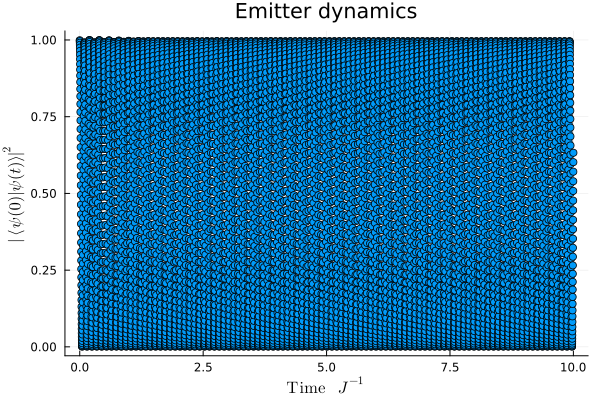

In [11]:
# plot evolution
using Plots
scatter(times,fidelity, title="Emitter dynamics", xlab=L"\textrm{Time}\quad J^{-1}", ylab=L"|\langle \psi(0) | \psi(t) \rangle |^2", legend=false)

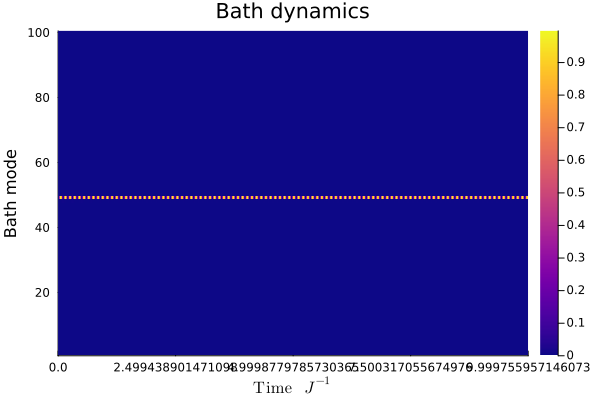

In [12]:
# plot evolution of bath
using Plots

function pixelated_heatmap(data; xlabel="", ylabel="", title="", color=:plasma, gridcolor=:white, lw=0.5)
    nrows, ncols = size(data)
    heatmap(data, 
            interpolate = false,     
            xlabel = xlabel,
            ylabel = ylabel,
            color = color,
            colorbar=:right,
            title = title)
    #vline!(0.5:1:(ncols+0.5), color=gridcolor, lw=lw, label="")
    #hline!(0.5:1:(nrows+0.5), color=gridcolor, lw=lw, label="")
end

pixelated_heatmap(bath_evolution, xlabel=L"\textrm{Time}\quad J^{-1}", ylabel="Bath mode", title="Bath dynamics")
col_idxs = Int.(round.(range(1,size(bath_evolution,2), length=5)))
xticks!(col_idxs, string.(times[col_idxs]))

In [92]:
N,J = 100,1.0
times = collect(0:0.1:10) # units of 1/J
ψ_0 = zeros(N+1)
ψ_0[1] = 1.0 # excited QE, empty bath

using Printf #string formatting

for δ in [1]
    for g in 10 .^ collect(-2.0:0.5:2.0)
        #evolve
        H_bath = NNTBHamiltonian(N,J)
        H = singleExHamiltonian(H_bath, δ, g, i=50, real_basis=true) 
        fidelity, bath_evolution = evolveState(ψ_0, H, times, real_basis=true)
        
        # save plots
        folder = "dynamics_N$(N)_δ$(δ)"
        mkpath(folder) # Create the folder if it doesn’t exist
        filename = joinpath(folder, "g$( @sprintf("%.2f", g) ).png")
        
        l = @layout [a; b]
        p1 = scatter(times,fidelity,  
             xlab="", 
             ylab=L"|\langle \psi(0) | \psi(t) \rangle |^2",
             legend=false)
        p2 = heatmap(times,1:size(bath_evolution,1),bath_evolution,
             interpolate = false,     
             xlabel=L"\textrm{Time}\quad J^{-1}",
             ylabel="Bath mode",
             color=:plasma,
             colorbar=false)
        img = plot(p1, p2, 
                   layout=l,  
                   link=:x,
                   heights=[0.2,0.8],
                   size=(700, 700))
        save(filename, img)
    end
end

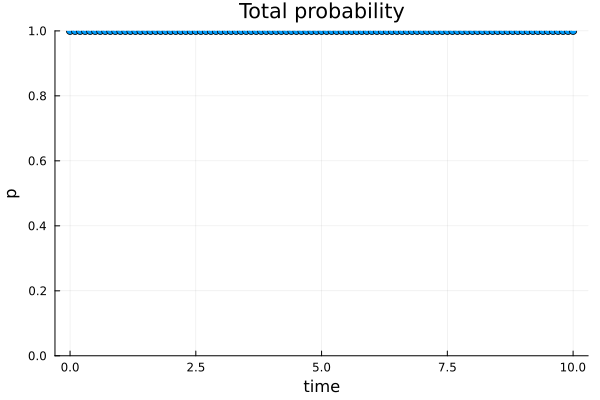

In [128]:
marginals = sum(bath_evolution; dims=1)[1,:] # sum all rows elementwise
scatter(times,marginals + fidelity, title="Total probability", xlab="time", ylab="p", ylim=(0,1),legend=false)
